# Ejercicio 2. SVM y Regresión Logística

**Ajuste una Máquina de Soporte de Vectorial a los datos de COVID**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix
from sklearn import metrics
from sklearn.metrics import precision_recall_curve

Iniciamos cargando los datos que vamos a usar:

In [2]:
data = pd.read_csv('covid.csv')
data.pop('Unnamed: 0') # Nos deshacemos de la columna con los índices de paciente.
data.head(2)

,SEXO,OBESIDAD,DIABETES,EPOC,ASMA,CARDIOVASCULAR,RENAL CRONICA,INMUNOSUPRESION,HIPERTENSION,TIPO PACIENTE,EDAD
0,MUJER,NO,NO,NO,NO,NO,NO,NO,NO,AMBULATORIO,51
1,MUJER,NO,NO,NO,NO,NO,NO,NO,NO,AMBULATORIO,37


Separamos el dataframe en las variables feature (X) y target (y). A la segunda le apllicamos un mapeo a 0 y 1:

In [3]:
y=LabelEncoder().fit_transform(data["TIPO PACIENTE"])
X=data.drop(["TIPO PACIENTE"],axis=1)

### a) Aplique OneHotEncoder a las variables categóricas.

La única variable que no es categórica es la edad:

In [4]:
categorical = list(X.columns)
categorical.remove("EDAD")
numerical = ["EDAD"]

En un inició pensé en únicamente realizar las transformaciones fuera de la pipeline, pero tras ver leer en la documentación de scikitlearn que esto puede ocasionar resultados sesgados por leaks de información del conjunto de validación al conjunto de entrenamiento, y que ellos recomiendan manejarlo dentro de un pipeline, decidí mejor dejarlo como en el ejemplo.


Definimos entonces un Pipeline que dentro maneja el **One Hot Encoding** para las variables categóricas que se nos pide en este inciso. Adicional a eso, aplicamos una discretización en Bins a la edad para hacer más sencillo su manejo dentro de un clasificador. 

In [5]:
def modelo(X_train, y_train, numeric_features, categorical_features, classifier):
    # No manejamos imputer porque nuestros datos ya vienen limpios y
    # queremos que sea lo más óptimo posible por la cantidad de datos que tenemos. 
    kbd = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
    # Aquí está el One-Hot Encoding que se nos pide en el ejercicio.
    ohe = OneHotEncoder(handle_unknown='ignore')
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', kbd, numeric_features),
            ('cat', ohe, categorical_features)
        ])
    # Pipeline principal con el preprocesamiento y el clasificador
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', classifier)])
    modelo=clf.fit(X_train, y_train)
    return modelo

### b) Ajuste un kernel lineal

Como la complejidad computacional de entrenar una máquina de soporte vectorial es algo alta cuando tenemos un gran número de datos, vamos a realizar una muestra aleatoria para entrenar con alrededor de 7,000 datos (específicamente, 6950, el 2% de nuestros datos totales). <br>

Así mismo, vamos a hacer otro muestreo para los datos de validación en una proporción similar, quedándonos con 6811 datos. <br>

Para realizar esto lo que haremos es usar train_test_split dos veces, pues nos asegura que la proporción de datos con ambas etiquetas se mantiene.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.98, random_state=42)

In [7]:
X_test, X_test1, y_test, y_test1 = train_test_split(X_test, y_test, test_size=0.98, random_state=43)

In [8]:
print("Número de datos de entrenamiento: ", X_train.shape[0])
print("Número de datos de validación: ", X_test.shape[0])

Número de datos de entrenamiento:  6950
Número de datos de validación:  6811


In [9]:
svmlinear = svm.LinearSVC(C=100,max_iter=100000, dual=False)
svm_model = modelo(X_train, y_train, numerical, categorical, svmlinear)

Vemos rápidamente con un accuracy qué tan bien clasifica el modelo los datos de validación:

In [10]:
y_p = svm_model.predict(X_test)
acc_svm = accuracy_score(y_test, y_p)
print("Precisión del modelo SVM: ", acc_svm)

Precisión del modelo SVM:  0.7536338276317721


### c) Compare su resultado de ese mismo subconjunto contra un modelo de regresión logı́stica.

Obtenemos el ajuste de un modelo logístico sin optimizar hiperparámetros primero, luego con una optimización de hiperparámetros.

In [11]:
reglog = LogisticRegression(fit_intercept = True, C=2.5,
                            solver='lbfgs', tol=1e-5, max_iter=75,
                            n_jobs = 8)
reglog_model = modelo(X_train, y_train, numerical, categorical, reglog)

Vemos qué tal lo hace este modelo y compararemos contra la SVM

In [12]:
y_p = reglog_model.predict(X_test)
acc_log = accuracy_score(y_test, y_p)
print("Precisión del modelo de Regresión Logística: ", acc_log)

Precisión del modelo de Regresión Logística:  0.7573043605931581


En este caso ambos modelos de tienen una precisión muy similar, pero el SVM lo hace ligeramente mejor (pero sólo como por 0.5%)

In [13]:
def gridsearch_log():
    clf = LogisticRegression(fit_intercept=True,solver='lbfgs',tol=1e-5,max_iter=75,n_jobs=8)
    grid_values = {'penalty': [ 'l2'],'C':np.logspace(-5, 5, 100)}
    grid_clf_acc = GridSearchCV(clf, param_grid = grid_values,scoring = 'accuracy')
    return grid_clf_acc

In [14]:
gr = gridsearch_log()
reglog_opt = modelo(X_train, y_train, numerical, categorical, gr)

In [15]:
y_p = reglog_opt.predict(X_test)
acc_log = accuracy_score(y_test, y_p)
print("Precisión del modelo de Regresión Logística optimizado: ", acc_log)

Precisión del modelo de Regresión Logística optimizado:  0.7574511819116135


Lo hace ligeramente mejor, pero el resultado es esencialmente el mismo, una precisón de alrededor de 75.7%.

### d) De los modelos anteriores obtenga la matriz de confusión y la curva ROC.

**Matrices de Confusión**

In [16]:
def plot_cm(model, X_test, y_test, title):
    disp=plot_confusion_matrix(model, X_test, y_test,
                               normalize="pred",
                               display_labels=np.array(["NO","SI"]))
    disp.ax_.set_title(title)
    disp.confusion_matrix

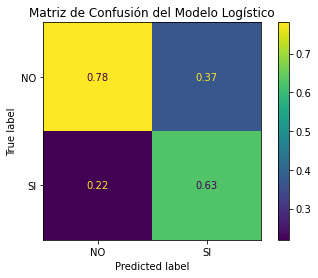

In [17]:
plot_cm(reglog_opt, X_test, y_test, "Matriz de Confusión del Modelo Logístico")

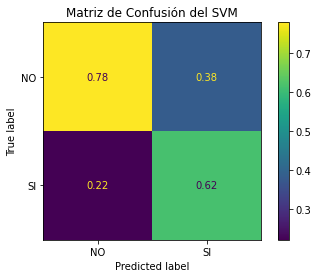

In [18]:
plot_cm(svm_model, X_test, y_test, "Matriz de Confusión del SVM")

Al realizar este análisis vemos que ambos clasificadores se están equivocando prácticamente en lo mismo. De hecho, en general, salvo cambios ligeros de 0.01 están clasificando en cantidades muy similares a los datos.

**Curvas ROC**

In [19]:
# Función auxiliar para no repetir el código de gráficación de ROC.
def plot_roc(names, y_test, y_preds):
    fig = plt.figure(figsize=(10, 5*len(names)))
    index = 1
    for name in names:
        fpr, tpr, threshold = metrics.roc_curve(y_test, y_preds[index-1])
        roc_auc = metrics.auc(fpr, tpr)
        fpr, tpr, threshold = metrics.roc_curve(y_test, y_preds[index-1])
        ax = fig.add_subplot(2, len(names), index)
        ax.plot(fpr, tpr, label=f"ROC {name}  (area = {roc_auc:0.2f})")
        # Identidad
        ax.plot([0, 1], [0, 1],'r--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('Tasa de falsos positivos')
        ax.set_ylabel('Tasa de verdaderos positivos')
        ax.set_title(f"curva ROC {name}")
        ax.legend(loc="lower right")
        index+=1
    plt.tight_layout()
    plt.show()

Obtenemos las predicciones de ambos modelos:

In [20]:
y_preds_log = reglog_opt.predict_proba(X_test)[:,1]
# LinearSVC no probee de un método para obtener las probabilidades, por lo que 
# nuestra curva ROC tendrá que hacerse con las etiquetas, y consistirá de dos líneas únicamente.
y_preds_svm = svm_model.predict(X_test)
y_preds_all = [y_preds_log, y_preds_svm]

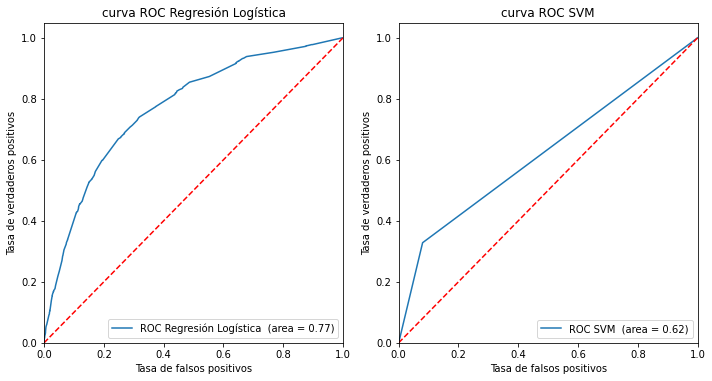

In [21]:
plot_roc(["Regresión Logística", "SVM"], y_test, y_preds_all)

Al analizar las curvas, vemos que si bien en precisión la SVM no se veía tan mal, su desempeño sí es notablemente menor al de la regresión logística optimizada, aunque probablemente sea porque no podemos acceder a las probabilidades detrás de la decisión de la clasificación de este modelo.

In [22]:
def print_stats(model, name, X_test, y_test):
    predictions=model.predict(X_test)
    print(f'Accuracy score {name}: ', format(accuracy_score(y_test, predictions)))
    print(f'Precision score {name}: ', format(precision_score(y_test, predictions)))
    print(f'Recall score {name}: ', format(recall_score(y_test, predictions)))
    print(f'F1 score {name}: ', format(f1_score(y_test, predictions)))

In [23]:
print_stats(reglog_opt, "Logística", X_test, y_test)

Accuracy score Logística:  0.7574511819116135
Precision score Logística:  0.627431906614786
Recall score Logística:  0.33699059561128525
F1 score Logística:  0.4384772263766145


In [24]:
print_stats(svm_model, "SVM", X_test, y_test)

Accuracy score SVM:  0.7536338276317721
Precision score SVM:  0.615686274509804
Recall score SVM:  0.3281086729362591
F1 score SVM:  0.4280845262440354


### e) Haga una optimización de hiperpametros priorizando la precisión.

Ahora es momento de ver qué tanto podemos mejorar la svm con optimización de hiperparámetros.

Los hiperparámetros que vamos a optimizar son:
* C: Parámetro de regularización
* max_iter, numero máximo de iteraciones.
* penalty, la función de penalización (l2 o l1)

Los que dejaremos fijos son:
* dual = False; siguiendo la recomendación de la documentación, que sugieren usar así este parámetro cuando n_features < n_observaciones, además de que aligera la complejidad bastante. 

In [26]:
def gridsearch_svm():
    clf = svm.LinearSVC(dual=False)
    grid_values = {'C':np.logspace(-2, 3, 25), 'penalty':['l2', 'l1'],
                   'max_iter': [100_000, 150_000]}
    grid_clf_acc = GridSearchCV(clf, param_grid = grid_values, scoring = 'accuracy')
    return grid_clf_acc

In [27]:
svm_hyper = gridsearch_svm()
svm_opt = modelo(X_train, y_train, numerical, categorical, svm_hyper)

In [28]:
y_p = svm_opt.predict(X_test)
acc_svm_opt = accuracy_score(y_test, y_p)
print("Precisión del modelo de SVM optimizado: ", acc_svm_opt)

Precisión del modelo de SVM optimizado:  0.7533401849948612


### f) Para el modelo logístico: Haga una gráfica de Precision-Recall vs Threshold

(0.0, 1.0)

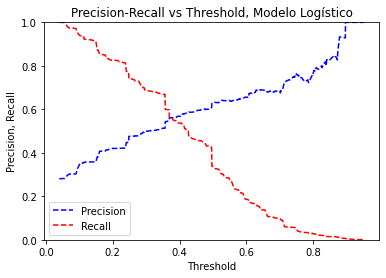

In [29]:
y_proba= reglog_opt.predict_proba(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_proba[:,1]) 
pr_auc = metrics.auc(recall, precision)
plt.title("Precision-Recall vs Threshold, Modelo Logístico")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])